# Lecture 3 - Optimization 

**Where is this useful?**

For example estimation og the Simulated Method of Moments (SMM):

- Estimation: optimizing some objective function $\mathrm{SMM}: \min _{\theta} \mathrm{M}(\theta)^{\prime} W(\theta) \mathrm{M}(\theta)$ where
$$
M(\theta)=\frac{1}{N} \Sigma_{i} M_{i}(\theta)=\frac{1}{N} \Sigma_{i}\left(y_{i}(\theta)-y_{i}^{\text {data }}\right)
$$
MLE: $\max _{\theta} \log [L(\theta)]$ where
$$
\log [L(\theta)]=\frac{1}{N} \Sigma_{i} \log L_{i}(\theta)=\frac{1}{N} \Sigma_{i} \log L_{i}\left(y_{i}^{\text {data }} \mid \theta\right)
$$
* Challenges Lack of analytical gradient
    * No analytical expression for value function.
* $\mathrm{M}_{\mathrm{i}}(\theta)$ and $\mathrm{L}_{\mathrm{i}}(\theta)$ got from solving dynamic models (time-consuming)

We will use [`Optim.jl`](https://github.com/JuliaNLSolvers/Optim.jl) package for univariate and multivariate optimization of functions. Documentation is available [here](https://julianlsolvers.github.io/Optim.jl/stable/).

In [1]:
# import Pkg; Pkg.add("Optim");
using Optim, Plots

## Outline

- [Brute-force](##Brute-force): enumerate all candidates
- Derivative free: Nelder Mead
- Derivative needed
    - Univariate optimization: Brent's method
    - Multivariate optimization
        - Newton-type algorithm (analytical gradient available)
        - BFGS, LBFGS, BHHH (analytical gradient not available/efficient: use numerical approximation)

## Brute-force metod
- Is used when:
    - parameter is low dimensional or
    - finding a plausible initial guess.
- It can be accelerated by parallelization.
- Infeasible when the parameter is high-dimensional.

## Derivative-Free method
- Workhorse method: Nelder-Mead
    - Essentially an intelligent grid search
    - Starts with simplex and moves/shrinks simplex downhill
- First proposed in 1965
- Original algorithm turned out to have horrible theoretical properties
    - Lagarias et al (1998): "A counterexample $\ldots$ Gives a family of strictly convex functions in two dimensions and a set of initial conditions for which the Nelder-Mead algorithm converges to a non-minimizer."

## Box-constrained univariate optimization
- Examples
    - Choice of search intensity, normalized between 0 and 1
    - Choice of labor supply between 0 and 60 hours
    - Choice of next-period assets over asset space
- Relatively easy case
    - Most common method used: Brent's method
    - Essentially an intelligent grid search using secants and bisections
    - Fairly robust and fast

### Bretn's method

* Next is a simple example of constrainde minimization problem and its solution using the implementation of Brent´s Method in `Optim.jl`.

* Details on the method and the algorithm can be get from [Brent's method](https://en.wikipedia.org/wiki/Brent%27s_method) wikepedia page.

In [2]:
## Brent's method
f(x, y) = (x-y)^2
# syntax: optimize(function, min_x, max_x)
opt = optimize(x->f(x, 1.0), -5.0, 5.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-5.000000, 5.000000]
 * Minimizer: 1.000000e+00
 * Minimum: 0.000000e+00
 * Iterations: 5
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 6

Consider next a more complicated problem:

We want to find the minimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) which is a non-convex function defined as:
$$f(x,y) = (a-x)^2 + b(y-x^2)^2$$

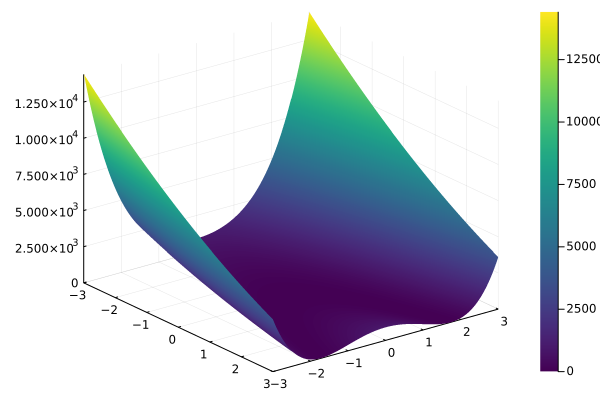

In [3]:
## Rosenbrock with a=b=1
# global minimum (x1 = 1, x2 = 1)
function Rosenbrock(vec::Vector{Float64})
    x1, x2 = vec[1], vec[2]
    val = (1 - x1)^2 + 100 * (x2 - x1^2)^2
end

# evaluate function at a bunch of points
x_grid = collect(-3:0.01:3)
nx = length(x_grid)
z_grid = zeros(nx, nx) # Create a 2D array 

for i = 1:nx, j = 1:nx
    guess = [x_grid[i], x_grid[j]]
    z_grid[i,j] = Rosenbrock(guess)
end

# plot
Plots.surface(x_grid, x_grid, z_grid, seriescolor=:viridis, camera = (50,50))

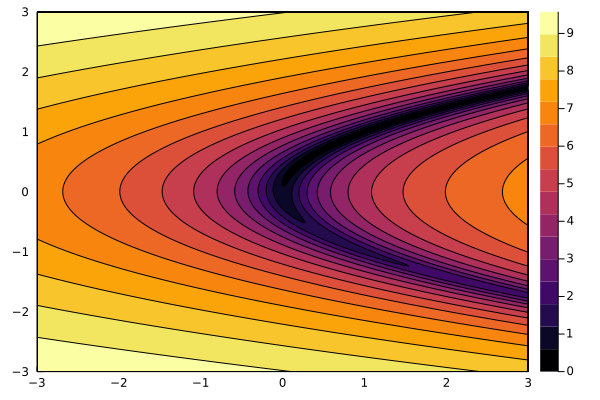

In [32]:
# To get back to the original backend use
Plots.contourf(x_grid, x_grid, log.(1 .+ z_grid), seriescolor=:inferno)

Note tha the global minimum is $(1,1)$ but as we can see in the contour plot, there is a region where the function has very similar values.

This difficults the optimization process.

We start by using Nelder-Mead method with an initial guess of $(0,0)$.

In [31]:
### Nelder-Mead
guess = [0.0, 0.0]
# syntax: optimize(function, initial guess)
opt = optimize(Rosenbrock, guess)

 * Status: success

 * Candidate solution
    Final objective value:     3.525527e-09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    60
    f(x) calls:    117


In [8]:
# To obtain the minimizer use:
opt.minimizer

2-element Vector{Float64}:
 0.9999634355313174
 0.9999315506115275

## Multivariate Optimization
- How to best optimize multivariate functions depends on the availability of the function's derivatives.
- If function is twice-differentiable and has analytic gradient/Hessian, just provide gradient/Hessian optimization algorithm.
    - Newton-Rhapson
- Otherwise, use quasi-Newtonian methods when
    - No analytical gradients (model is complex)
    - Calculating analytical gradient is time-consuming (e.g., apply implicit function theorem and inverting matrices).

### Newton-Rhapson method
$$
\max _{\beta} I(\beta)
$$
Taylor expansion around $\mathrm{k}$ -th parameter guess $\beta^{\mathrm{k}}$
$$
I(\beta) \approx I\left(\beta^{k}\right)+g\left(\beta^{k}\right)\left(\beta-\beta^{k}\right)+1 / 2\left(\beta-\beta^{k}\right)^{\prime} H\left(\beta^{k}\right)\left(\beta-\beta^{k}\right)
$$

Where $\mathrm{g}\left(\beta^{k}\right)$ and $\mathrm{H}\left(\beta^{k}\right)$ are gradient and Hessian at $\beta^{k}$ 
* $\mathrm{FOC}$ wrt $\beta$: $$\mathrm{g}\left(\beta^{k}\right)+H\left(\beta^{k}\right)\left(\beta-\beta^{k}\right)=0$$
* Update $\beta^{k+1}=\beta^{k}-H\left(\beta^{k}\right)^{-1} g\left(\beta^{k}\right)$


NR method is preferable when the function is globally concave (e.g. Probit)

### Quasi-Newtonian Methods
- Essentially applies Newton's method but with numerical approximates of the gradient.
$$
\beta^{k+1}=\beta^{k}-\mathbf{H}\left(\beta^{k}\right)^{-1} \mathbf{g}\left(\beta^{k}\right)
$$ 
where $\mathbf{H}\left(\beta^{k}\right)^{-1}$ and $\mathbb{g}\left(\beta^{k}\right)$ are numerical approximations of the Hessian and gradient.

There are two ways of calculating the numerical approximations:
- Finite differences: perturb the function input slightly and see how output changes (default)
- Automatic differentiation: Chain rule is calculated numerically. Allows computer to establish rules/heuristics for the derivatives of functions.
- Most common algorithm of this type: BFGS. 
    * Or LBFGS

In [34]:
### LBFGS
# syntzx: optimize(function, initial guess, optimization options)
opt = optimize(Rosenbrock, guess, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     5.378388e-17

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.54e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.54e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.85e-19 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.30e-03 ≰ 0.0e+00
    |g(x)|                 = 9.88e-14 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    24
    f(x) calls:    67
    ∇f(x) calls:   67


In [35]:
opt.minimizer

2-element Vector{Float64}:
 0.9999999926662504
 0.9999999853325008

In [37]:
## Define Gradient
# Seems that optimize() requires gradient & Hessian be defined with in-place function
function g(G, guess::Vector{Float64})
    x, y = guess[1], guess[2]
    G[1] = -2.0 * (1.0 - x) - 400.0 * (y - x^2) * x
    G[2] = 200.0 * (y - x^2)
    G #return
end

# Hessian
function h(H, guess::Vector{Float64})
    x, y = guess[1], guess[2]
    H[1,1] = 2.0 - 400.0 * y + 1200.0 * x^2
    H[1,2] = -400.0 * x
    H[2,1] = -400.0 * x
    H[2,2] = 200.0
    H #retturn
end

h (generic function with 1 method)

Next ew will compare the performance of the methods:
* `BFGS()`
* Nelder-Mead with  with user supplied gradient and Hessian

In [40]:
using BenchmarkTools
# Nelder_Mead
guess = [0.0, 0.0]
@benchmark opt = optimize(Rosenbrock, g, h, guess)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  25.200 μs …   9.358 ms  ┊ GC (min … max): 0.00% … 99.49%
 Time  (median):     28.400 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   34.809 μs ± 160.289 μs  ┊ GC (mean ± σ):  7.93% ±  1.72%

  ▇█▇▇▇▅▅▄▃▁▁      ▁▁▂▁▂▂▁▁▁▁                                  ▂
  █████████████▇▇██████████████▇▇▇▆▆▆▇▇██▇▇▇▇▆▆▆▅▇▆▆▆▇▆▆▆▇▅▅▆▄ █
  25.2 μs       Histogram: log(frequency) by time      82.1 μs <

 Memory estimate: 23.73 KiB, allocs estimate: 426.

In [41]:
@benchmark opt = optimize(Rosenbrock, guess, BFGS())

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  29.200 μs …  10.913 ms  ┊ GC (min … max): 0.00% … 99.16%
 Time  (median):     34.000 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   39.641 μs ± 182.335 μs  ┊ GC (mean ± σ):  7.92% ±  1.72%

  ▅▆▆▆▇██▆▄▃▃▂▂       ▁▁▂▂▁▁▁▁▁                                ▂
  ████████████████▇███████████████▇▆▇▄▇▆▆▅▆▇▅▆▇▇▇▆▆▆▇▆▅▅▆▅▆▄▆▅ █
  29.2 μs       Histogram: log(frequency) by time      79.1 μs <

 Memory estimate: 22.58 KiB, allocs estimate: 514.

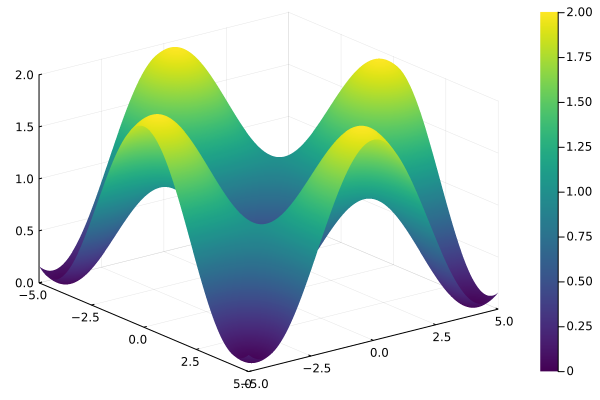

In [49]:

## Lots of local minima
function Greiwank(x::Array{Float64})
    return (1/4000)*sum(x.^2) - prod(cos.(x./sqrt(length(x)))) + 1
end

### evaluate function at a bunch of points
x_grid = collect(-5:0.01:5)
nx = length(x_grid)
z_grid = zeros(nx, nx)

for i = 1:nx, j = 1:nx
    guess_val = [x_grid[i], x_grid[j]]
    z_grid[i,j] = Greiwank(guess_val)
end

### plots
Plots.surface(x_grid, x_grid, z_grid, seriescolor=:viridis, camera = (50,50))


In [50]:
Plots.contourf(x_grid, x_grid, z_grid, seriescolor=:inferno)

In [54]:
### global optimum at (0,0)
guess_init = [3.0, 3.0]
opt = optimize(Greiwank, guess_init) #this fails!

 * Status: success

 * Candidate solution
    Final objective value:     9.859749e-03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    30
    f(x) calls:    62


In [55]:
opt.minimizer

2-element Vector{Float64}:
 4.438378496958502
 4.438551822303198

In [56]:
#now this works!
guess_init = [2.0, 2.0]
opt = optimize(Greiwank, guess_init) #this works!

 * Status: success

 * Candidate solution
    Final objective value:     2.139827e-09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    43
    f(x) calls:    89


In [57]:
opt.minimizer

2-element Vector{Float64}:
  6.645897449581333e-6
 -9.2231179443028e-5

**Important Caveats: Initial Guesses**
- Convexity again matters
- Multivariate optimization routines usually require a starting guess.
- This guess matters
    - Can affect the speed at which the solution is found considerably.
    - A bad guess can also result in the algorithm obtaining the wrong answer.
- Best practice: try to provide reasonable guesses and assess robustness of algorithm to alternate guesses.

In [63]:
#try multiple starts!
# I will add a little of printing to show whats going on   
function Multistart()
    x_grid = collect(-5:0.5:5)
    nx = length(x_grid)
    minimum, minimizers = 100, [100, 100] # initial (bad) guesses for minimum and minimizes
    println("Start with the minimizers $minimizers and objective function value of $minimum\n")
    for i = 1:nx, j = 1:nx
        guess = [x_grid[i], x_grid[j]] #starting guess
        opt = optimize(Greiwank, guess) #nelder-mead with new starting guess
        if opt.minimum<minimum #new minimum!
            minimum = opt.minimum #update
            minimizers = opt.minimizer #update
            println("Minimizers updated to $minimizers in iteration $i  objective function value now of $minimum")
        end
    end
    minimum, minimizers #return
end

Multistart (generic function with 1 method)

In [64]:
min, minimizers = Multistart();

Start with the minimizers [100, 100] and objective function value of 100

Minimizers updated to [-4.438407082979987, -4.438457724054828] in iteration 1  objective function value now of 0.009859745017783417
Minimizers updated to [-4.438468428336103, -4.4384385236643125] in iteration 1  objective function value now of 0.009859744776633317
Minimizers updated to [-4.438438024328006, -4.438430085947631] in iteration 1  objective function value now of 0.009859744686208538
Minimizers updated to [-1.1069577093412674e-5, -9.456367998174811e-5] in iteration 4  objective function value now of 2.2684724099164555e-9
Minimizers updated to [-2.9956641731853484e-5, 3.01267313312106e-5] in iteration 4  objective function value now of 4.5170633899971335e-10
Minimizers updated to [1.7117932233955062e-5, 3.448642287426755e-5] in iteration 5  objective function value now of 3.709548224151149e-10
Minimizers updated to [1.6099441447243543e-6, 3.564654656704545e-5] in iteration 5  objective function value now

**Important Caveats: Tolerance Level**

SMM: $$M(\theta)=\frac{1}{N} \Sigma_{i} M_{i}(\theta)=\frac{1}{N} \Sigma_{i}(y_i(\theta)-y_i^{\text{data}})$$
- Estimation routine:
    - Inner loop: guess $\theta$, solve model (e.g., value function iteration), and generate model prediction $y_{i}(\theta)$
    - Outer loop: vary $\theta$, find minimum $\| y_{i}(\theta)-y_{i}^{d a t a}||$
- Tolerance levels for inner and outer loops.
    - Loose tolerance may lead to local minimum.
    - Loose inner tolerance may lead to slower convergence: model prediction isn't responsive to a change in parameter guess.
    - Dubé, J. P., Fox, J. T., \& Su, C. L. (2012). Improving the numerical performance of static and dynamic aggregate discrete choice random coefficients demand estimation. Econometrica, $80(5)$, 2231-2267.

In [65]:
## OLS example
using Distributions, Random

# run the same OLS as first class
dist = Normal(0,1)
β_0 = 1.0; β_1 = 2.0; β_2 = 3.0;
n = 10000;
x = rand(n).*10;
x2 = x.^2;
ϵ = rand(dist, n) ## generate random shocks
Y_data = β_0 .+ β_1.*x + β_2.*x2 .+ ϵ
X = hcat(ones(n), x, x2)
β_ols = inv(X' * X) * X' * Y_data

### ols-nelder function
function OLS_Nelder(β::Array{Float64,1})
    β_0, β_1, β_2 = β[1], β[2], β[3] #unpack β
    ϵ = Y_data - (β_0 .+ β_1.*x + β_2.*x2)
    return error = sum(ϵ.^2) #sum of squared error
end

OLS_Nelder (generic function with 1 method)

In [68]:
#do OLS with nelder-mead
guess_init = [0.0, 0.0, 0.0]
opt = optimize(OLS_Nelder, guess_init) #it works
println("Estimate")
println(opt.minimizer)
println(propertynames(opt)) # show argument names in opt
println("Analytical Solution")
println(β_ols)

Estimate
[0.9564117968245958, 2.015980408868037, 2.9990569093019688]
(:method, :initial_x, :minimizer, :minimum, :iterations, :iteration_converged, :x_converged, :x_abstol, :x_reltol, :x_abschange, :x_relchange, :f_converged, :f_abstol, :f_reltol, :f_abschange, :f_relchange, :g_converged, :g_abstol, :g_residual, :f_increased, :trace, :f_calls, :g_calls, :h_calls, :ls_success, :time_limit, :time_run, :stopped_by)
Analytical Solution
[0.9564124653452508, 2.015979987465147, 2.9990569318979206]


In [69]:
# Let's try a tighter tolerance level
opt = optimize(OLS_Nelder, guess_init, BFGS(), Optim.Options(x_tol=1e-17,f_tol=1e-17,g_tol=1e-17))
println("Estimate")
println(opt.minimizer)
println(propertynames(opt)) # show argument names in opt
println("Analytical Solution")
println(β_ols)

Estimate
[0.9564124652300908, 2.0159799875105073, 2.9990569318941853]
(:method, :initial_x, :minimizer, :minimum, :iterations, :iteration_converged, :x_converged, :x_abstol, :x_reltol, :x_abschange, :x_relchange, :f_converged, :f_abstol, :f_reltol, :f_abschange, :f_relchange, :g_converged, :g_abstol, :g_residual, :f_increased, :trace, :f_calls, :g_calls, :h_calls, :ls_success, :time_limit, :time_run, :stopped_by)
Analytical Solution
[0.9564124653452508, 2.015979987465147, 2.9990569318979206]


# Extra: Tricks to convert contraint optimization to unconstrained optimization

## Simplify constrained optimization
Reference: [Jason Blevins - Some Useful Bijections](https://jblevins.org/notes/bijections) Use transformation of variables to convert a constrained optimization problem to an unconstrained one.

| Useful Bijections |  |  |
| :--- | :--- | :--- |
| A | Rrarr A | A rarrR |
| [0,oo) | e^(x) | ln(x) |
| (-oo,0] | -e^(x) | ln(-x) |
| [0,1] | (1)/(1+e^(-x)) | -ln((1)/(theta)-1) |
| [-1,1] | (2)/(1+e^(-x))-1 | -ln((2)/(theta+1)-1) |

* Note: sometimes $\exp (x)$ is sensitive to large $x .$ One can use $\ln (1+\exp (x))$ 
* Remember to apply chain rule for the transformed variable!

A multidimensional transformation is useful when the parameters represent probabilities.
$$
\begin{gathered}
A=\left\{\left(\theta_{1}, \theta_{2}, \ldots, \theta_{n}\right) \mid 0 \leq \theta_{i} \leq 1 \quad \text { and } \quad \sum_{i} \theta_{i}=1\right\} \\
\phi_{i}(x)=\frac{e^{x_{i}}}{1+\sum_{j=1}^{n-1} e^{x_{j}}}
\end{gathered}
$$
for $1 \leq i \leq n-1$ and
$$
\phi_{n}(x)=\frac{1}{1+\sum_{j=1}^{n-1} e^{x_{j}}}
$$